# Investment Porfolio Snapshot Tool

Given simple daily prices for a few ETFs and a weights table, produce a single-day snapshot of:

* each ETF’s daily return
* the weighted portfolio daily return
* rolling 20-day volatility per ETF
* portfolio drawdown series
* a clean plot with price + moving average and a proper legend

## Input

* `prices.csv` with columns: date, ticker, close (multiple tickers; daily rows; date in YYYY-MM-DD)
* `weights.csv` with columns: ticker, weight (weights sum to ~1; if not, you’ll normalise)

If you don’t have files handy, fabricate 60 trading days for 3–4 tickers with small random walks.

## What to Build

A function portfolio_snapshot(prices_path, weights_path, asof) that returns a dict with:

* etf_returns_asof: Series of today’s % return per ticker
* portfolio_return_asof: float for today’s weighted return
* vol_20d: Series of 20-day rolling volatility per ticker (as of asof)
* max_drawdown: float for portfolio max drawdown over the last 60 days
* (and it should generate a plot: chosen ETF’s close + 20-day MA, with both lines in the legend)

## Constraints / Rules

1. Validation (light but real):

* error if asof not in prices.date.
* if any weight is missing for a ticker in prices, set weight to 0 and warn.
* if weights don’t sum to 1 ± 1e-6, normalize and warn.

2. Case-when with loc: if an ETF’s 20-day volatility is NaN on asof, set it to the mean of its available rolling vol (simulate “impute recent vol”). Do this with loc, not a chained assignment.

3. Mapping: map tickers to a sector label using a tiny dict (e.g., {'VAS':'AU','VGS':'Global','NDQ':'US','VGE':'EM'}) and attach as a column with map.

4. No chained assignment. Use loc for in-place conditional edits.

5. Plot requirements:

* one ETF of your choice (param or pick the largest weight)
* line for close and line for 20-day MA
* both appear in the legend (explicit label= on each line; no silent handles)
* title includes asof; x-axis ticks auto; keep axis labels minimal

## Set up

### Libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Generate data

In [34]:
tickers = ["VAS", "VGS", "NDQ", "VGE"]
n_days = 60

# business-day date range
dates = pd.bdate_range(end="2025-11-07", periods=n_days)

# simulate random-walk close prices
prices = []
for t in tickers:
    start = np.random.uniform(90, 110)
    # small daily pct changes around 0 ± 1%
    rets = np.random.normal(0, 0.01, n_days)
    closes = start * np.cumprod(1 + rets)
    prices.append(pd.DataFrame({"date": dates, "ticker": t, "close": closes}))

prices_df = pd.concat(prices, ignore_index=True)

# ---- weights table ----
weights_df = pd.DataFrame({
    "ticker": tickers,
    "weight": [0.25, 0.35, 0.25, 0.15]  # roughly sums to 1
})

# preview
print(prices_df.head())
print(weights_df)

        date ticker      close
0 2025-08-18    VAS  92.847685
1 2025-08-19    VAS  93.197954
2 2025-08-20    VAS  91.584363
3 2025-08-21    VAS  91.859326
4 2025-08-22    VAS  90.751844
  ticker  weight
0    VAS    0.25
1    VGS    0.35
2    NDQ    0.25
3    VGE    0.15


In [35]:
asof = prices_df['date'].max()
print(asof)

2025-11-07 00:00:00


### Create the portfolio tool

In [36]:
def portfolio_snapshot(prices, weights, asof):
    ##########################
    # Data and format checks #
    ##########################
    print('Checking the data input format')
    print('------------------------------\n')

    # 1) Column checks (containment, not exact order)
    expected_prices = ['date', 'ticker', 'close']
    expected_weights = ['ticker', 'weight']

    missing_p = [c for c in expected_prices if c not in prices.columns]
    missing_w = [c for c in expected_weights if c not in weights.columns]

    if missing_p:
        print("Prices dataset missing columns:", missing_p)
        print("Expected at least:", expected_prices)
        return None
    if missing_w:
        print("Weights dataset missing columns:", missing_w)
        print("Expected at least:", expected_weights)
        return None

    # Work on copies so caller’s data isn’t mutated
    prices = prices.copy()
    weights = weights.copy()

    # 2) Type conversions (L2 style)
    try:
        prices['date'] = pd.to_datetime(prices['date'])
    except Exception:
        print("Error converting prices['date'] to datetime. Tip: use YYYY-MM-DD.")
        return None

    try:
        prices['ticker']  = prices['ticker'].apply(lambda x: str(x).strip())
        weights['ticker'] = weights['ticker'].apply(lambda x: str(x).strip())
    except Exception:
        print("Error converting ticker columns to string.")
        return None

    try:
        prices['close']   = prices['close'].apply(lambda x: float(x))
        weights['weight'] = weights['weight'].apply(lambda x: float(x))
    except Exception:
        print("Error converting numeric columns to float. Check for non-numeric values.")
        return None

    # 3) Basic content sanity checks
    if prices.empty:
        print("Prices dataset is empty.")
        return None
    if weights.empty:
        print("Weights dataset is empty.")
        return None

    bad_close = prices['close'].isna() | (prices['close'] <= 0)
    if bad_close.any():
        print(f"Found {bad_close.sum()} rows with NaN or non-positive closes in prices.")
        return None

    dup = weights['ticker'][weights['ticker'].duplicated()].unique()
    if len(dup) > 0:
        print("Weights has duplicate tickers:", dup.tolist())
        print("Tip: aggregate or keep only one row per ticker.")
        return None

    # 4) asof handling
    try:
        asof_ts = pd.to_datetime(asof)
    except Exception:
        print("Could not parse 'asof' as a date.")
        return None

    if asof_ts not in prices['date'].unique():
        print(f"asof ({asof_ts.date()}) not found in prices['date'].")
        print(f"Last available date is {prices['date'].max().date()}.")
        return None

    # 5) Ensure we have weights for all tickers in prices
    tickers_in_prices = sorted(prices['ticker'].unique())
    missing_in_weights = [t for t in tickers_in_prices if t not in set(weights['ticker'])]
    if missing_in_weights:
        print(f"Missing weights for {missing_in_weights}. Setting them to 0.0.")
        weights = pd.concat(
            [weights, pd.DataFrame({'ticker': missing_in_weights, 'weight': [0.0]*len(missing_in_weights)})],
            ignore_index=True
        )

    extra_in_weights = [t for t in weights['ticker'] if t not in set(tickers_in_prices)]
    if extra_in_weights:
        print(f"Weights include tickers without prices: {sorted(set(extra_in_weights))} (kept; may normalize).")

    # 6) Normalise weights
    wsum = weights['weight'].sum()
    if np.isclose(wsum, 0.0):
        print("Weights sum to 0. Cannot normalise.")
        return None
    if not np.isclose(wsum, 1.0, atol=1e-6):
        print(f"Normalising weights from sum={wsum:.6f} to 1.0")
        weights['weight'] = weights['weight'] / wsum

    if (weights['weight'] < 0).any():
        print("Negative weights found. Short weights are not allowed in this function.")
        return None

    print('\tThe data passed all checks!')
    print('\n')

    #####################
    # Data manipulation #
    #####################
    print('Computing daily returns')
    print('-----------------------\n')

    # Sort then compute pct_change per ticker
    prices = prices.sort_values(['ticker', 'date'])
    prices['ret'] = prices.groupby('ticker', sort=False)['close'].pct_change()

    # Wide tables for returns and closes
    R = prices.pivot(index='date', columns='ticker', values='ret').sort_index()
    C = prices.pivot(index='date', columns='ticker', values='close').sort_index()

    # Align weights to R’s columns
    w = weights.set_index('ticker')['weight']
    w = w.reindex(R.columns).fillna(0.0)

    ###############################
    # Portfolio series & drawdown #
    ###############################
    print('Computing portfolio series & drawdown')
    print('-------------------------------------\n')

    # Portfolio daily return series
    port_ret = R.dot(w)

    # Equity curve
    equity = (1 + port_ret).cumprod()

    # Drawdown series
    dd = equity / equity.cummax() - 1.0

    #######################################
    # Computing Rolling 20-day volatility #
    #######################################
    print('Computing rolling 20-day volatility')
    print('-----------------------------------\n')

    vol_20d = R.rolling(20).std()

    # Slice `asof`
    vol_asof = vol_20d.loc[asof_ts]

    # Impute NaNs: fill with each ticker's mean vol
    na_mask = vol_asof.isna()
    if na_mask.any():
        mean_vol_per_ticker = vol_20d.mean(skipna=True)
        vol_asof.loc[na_mask] = mean_vol_per_ticker.loc[na_mask.index[na_mask]]

    # Risk band from vol
    bins = [0, 0.01, 0.02, np.inf]
    labels = ["Low", "Med", "High"]
    risk_band = pd.cut(vol_asof, bins=bins, labels=labels, right=False, include_lowest=True)
    # ensure strings for easy printing; NaNs (shouldn’t be left) go to "High"
    risk_band = risk_band.astype(object).fillna("High")

    #############################
    # Sector mapping (simple)   #
    #############################
    print('Mapping tickers to sectors')
    print('--------------------------\n')

    sector_map = {'VAS':'AU', 'VGS':'Global', 'NDQ':'US', 'VGE':'EM'}
    sectors = pd.Series({t: sector_map.get(t, 'Other') for t in R.columns}, name='sector')

    ################
    # Plot (clean) #
    ################
    print('Building plot (close + 20D MA with legend)')
    print('-------------------------------------------\n')

    # pick ETF with largest weight
    etf_to_plot = w.idxmax() if len(w) else R.columns[0]
    series = C[etf_to_plot].dropna()
    ma20 = series.rolling(20).mean()

    # Use last ~60 rows for readability (if available)
    plot_df = pd.DataFrame({'close': series, 'ma20': ma20}).tail(60)

    plt.figure(figsize=(9, 4))
    plt.plot(plot_df.index, plot_df['close'], label=f'{etf_to_plot} Close')
    plt.plot(plot_df.index, plot_df['ma20'],  label='MA20')
    plt.title(f'{etf_to_plot} Close & MA20 — as of {asof_ts.date()}')
    plt.ylabel('Price')
    # x-label left blank; dates on x-axis are clear
    plt.legend()
    plt.tight_layout()
    plt.show()

    ######################
    # Presenting results #
    ######################
    print('Assembling snapshot outputs')
    print('---------------------------\n')

    # Today’s per-ticker returns (Series)
    etf_returns_asof = R.loc[asof_ts]

    # Max drawdown over last ~60 trading days
    max_drawdown_60 = dd.tail(60).min()

    # Build a neat summary table (optional)
    summary = pd.DataFrame({
        'weight': w,
        'sector': sectors,
        'ret_asof': etf_returns_asof,
        'vol20_asof': vol_asof,
        'risk_band': risk_band
    })

    # Print a compact summary
    print("\nSnapshot summary (as of", asof_ts.date(), "):")
    print(summary.round(4))
    print("\nPortfolio return (asof):", round(float(etf_returns_asof.dot(w)), 6))
    print("Max drawdown (last ~60 days):", round(float(max_drawdown_60), 4))

    # Bundle outputs
    result = {
        'etf_returns_asof': etf_returns_asof,         # Series
        'portfolio_return_asof': float(port_ret.loc[asof_ts]),
        'vol_20d': vol_asof,                           # Series (asof)
        'risk_band': risk_band,                        # Series (asof labels)
        'sectors': sectors,                            # Series (static)
        'max_drawdown_60d': float(max_drawdown_60),
        'weights_aligned': w,                          # Series aligned to R columns
        'returns_table': R,                            # DataFrame (full)
        'equity_curve': equity,                        # Series (full)
        'drawdown': dd                                 # Series (full)
    }

    return result


Checking the data input format
------------------------------

	The data passed all checks!


Computing daily returns
-----------------------

Computing portfolio series & drawdown
-------------------------------------

Computing rolling 20-day volatility
-----------------------------------

Mapping tickers to sectors
--------------------------

Building plot (close + 20D MA with legend)
-------------------------------------------



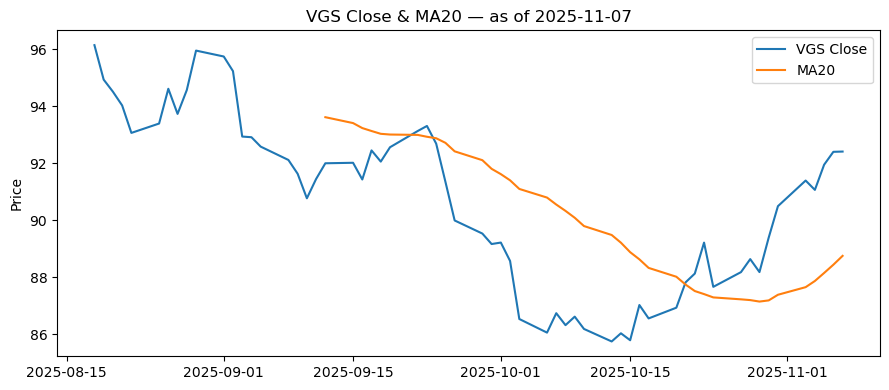

Assembling snapshot outputs
---------------------------


Snapshot summary (as of 2025-11-07 ):
     weight  sector  ret_asof  vol20_asof risk_band
NDQ    0.25      US   -0.0133      0.0093       Low
VAS    0.25      AU   -0.0181      0.0105       Med
VGE    0.15      EM    0.0036      0.0102       Med
VGS    0.35  Global    0.0001      0.0082       Low

Portfolio return (asof): -0.007298
Max drawdown (last ~60 days): -0.0849


{'etf_returns_asof': ticker
 NDQ   -0.013339
 VAS   -0.018135
 VGE    0.003566
 VGS    0.000101
 Name: 2025-11-07 00:00:00, dtype: float64,
 'portfolio_return_asof': -0.007298436363245086,
 'vol_20d': ticker
 NDQ    0.009347
 VAS    0.010489
 VGE    0.010207
 VGS    0.008219
 Name: 2025-11-07 00:00:00, dtype: float64,
 'risk_band': ticker
 NDQ    Low
 VAS    Med
 VGE    Med
 VGS    Low
 Name: 2025-11-07 00:00:00, dtype: object,
 'sectors': NDQ        US
 VAS        AU
 VGE        EM
 VGS    Global
 Name: sector, dtype: object,
 'max_drawdown_60d': -0.08494777250891217,
 'weights_aligned': ticker
 NDQ    0.25
 VAS    0.25
 VGE    0.15
 VGS    0.35
 Name: weight, dtype: float64,
 'returns_table': ticker           NDQ       VAS       VGE       VGS
 date                                              
 2025-08-18       NaN       NaN       NaN       NaN
 2025-08-19  0.002527  0.003773  0.005054 -0.012586
 2025-08-20 -0.016599 -0.017314 -0.019865 -0.004463
 2025-08-21  0.004248  0.003002 -0.01

In [37]:
portfolio_snapshot(prices_df, weights_df, asof)

# --- End of Challenge! ---